In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt(".../samsung_train.txt")
y_train = np.loadtxt(".../samsung_train_labels.txt").astype(int)

In [3]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

In [4]:
# Ваш код здесь
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

In [5]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [6]:
n_classes = np.unique(y).size

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
pca = PCA(n_components=66, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

In [9]:
# Ваш код здесь
exp_var_rat = 0
for i, components in enumerate(pca.components_):
    exp_var_rat += 100 * pca.explained_variance_ratio_[i]
    if exp_var_rat > 90:
        print('{} components explained {}% of initial variance'.format(i+1, round(exp_var_rat, 2)))
        break

66 components explained 90.15% of initial variance


1: 66

In [10]:
round(100 * pca.explained_variance_ratio_[0])

51.0

2: 51

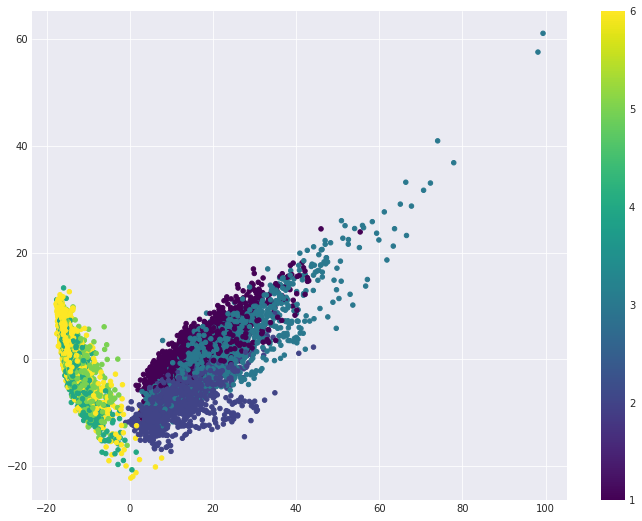

In [14]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')
plt.colorbar();

3:- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание) 

In [15]:

kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE).fit(X_pca)

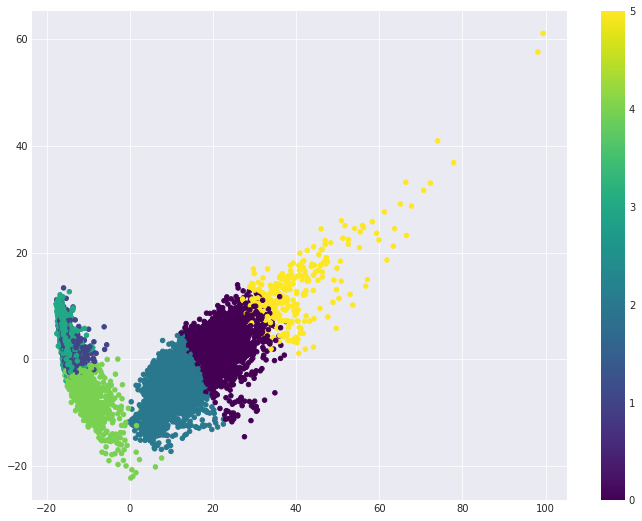

In [16]:
cluster_labels = kmeans.labels_
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20,  cmap='viridis')
plt.colorbar();

In [17]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,742,0,902,0,0,78,1722
подъем вверх по лестнице,295,0,1241,0,2,6,1544
спуск по лестнице,891,0,319,0,0,196,1406
сидение,0,1234,1,92,450,0,1777
стояние,0,1344,0,0,562,0,1906
лежание,0,53,5,1557,329,0,1944
все,1928,2631,2468,1649,1343,280,10299


In [18]:
our_metric = [max(tab.iloc[i, :6] / tab.iloc[i, 6]) for i in range(0, 7)]
tab['our_metric'] = our_metric
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все,our_metric
ходьба,742,0,902,0,0,78,1722,0.523810
подъем вверх по лестнице,295,0,1241,0,2,6,1544,0.803756
спуск по лестнице,891,0,319,0,0,196,1406,0.633713
сидение,0,1234,1,92,450,0,1777,0.694429
стояние,0,1344,0,0,562,0,1906,0.705142
лежание,0,53,5,1557,329,0,1944,0.800926
все,1928,2631,2468,1649,1343,280,10299,0.255462


4: нет верного ответа
подъем вверх по лестнице

In [19]:
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

A Jupyter Widget

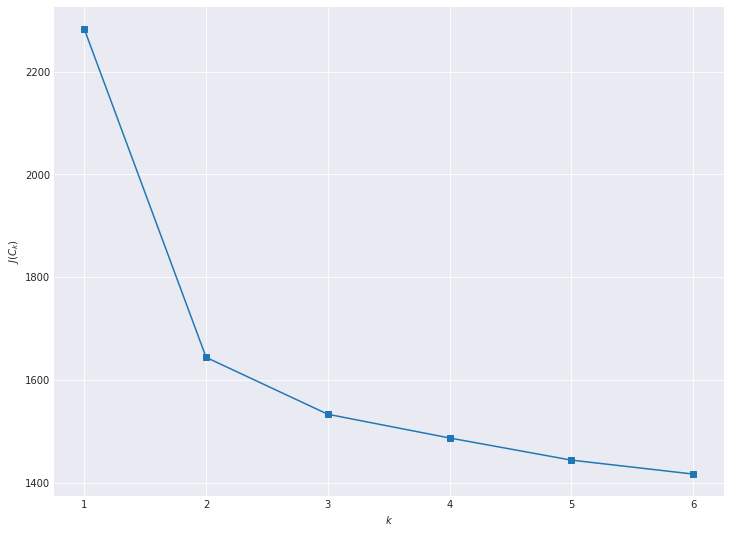

In [20]:
plt.plot(range(1, 7), inertia, marker='s')
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

5: 2

In [21]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_pca)

kmeans = KMeans(n_clusters=n_classes, n_init=100,
                random_state=RANDOM_STATE).fit(X_pca)

In [22]:
ari_ag = metrics.adjusted_rand_score(y, ag.labels_)
ari_kmeans = metrics.adjusted_rand_score(y, kmeans.labels_)
print(ari_ag, ari_kmeans)

0.517770453957 0.419596161028


6:
Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры


In [23]:
standard_scaled = StandardScaler()
X_train_scaled = standard_scaled.fit_transform(X_train)
X_test_scaled = standard_scaled.transform(X_test)

In [24]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [25]:
best_svc = GridSearchCV(svc, svc_params, cv=3).fit(X_train_scaled, y_train)

In [26]:
print(best_svc.best_params_, best_svc.best_score_)

{'C': 0.1} 0.938248095756


7: 0.1

In [27]:
y_predicted = best_svc.predict(X_test_scaled)

In [28]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,412,1,1,0,420
сидение,0,4,0,427,60,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,412,443,589,526,2947


8: по точности – стояние, по полноте – сидение

In [29]:
accuracy = {}
for i in range(0, 6):
    accuracy[tab.columns[i]] = tab.iloc[i, i] / tab.iloc[6, i]
sorted(accuracy.items(), key=lambda x: x[1])

[('стояние', 0.87775891341256362),
 ('сидение', 0.963882618510158),
 ('ходьба', 0.97244094488188981),
 ('подъем вверх по лестнице', 0.97867803837953093),
 ('спуск по лестнице', 1.0),
 ('лежание', 1.0)]

In [30]:
precision = {}
for i in range(0, 6):
    precision[tab.index[i]] = tab.iloc[i, i] / tab.iloc[i, 6]
sorted(precision.items(), key=lambda x: x[1])

[('сидение', 0.86965376782077397),
 ('стояние', 0.97180451127819545),
 ('подъем вверх по лестнице', 0.97452229299363058),
 ('лежание', 0.97951582867783982),
 ('спуск по лестнице', 0.98095238095238091),
 ('ходьба', 0.99596774193548387)]

9: 4%

In [31]:
pca = PCA(n_components=66, random_state=RANDOM_STATE)
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

best_svc_pca = GridSearchCV(svc, svc_params, cv=3).fit(X_train_scaled_pca, y_train)

In [32]:
print(best_svc_pca.best_params_, best_svc_pca.best_score_)

{'C': 1} 0.903155603917


In [33]:
round((best_svc.best_score_ - best_svc_pca.best_score_) * 100)

4.0

10:
PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком